# Comparing time series predictions of the global temperature

By: Sherif Abdulkader Tawfik Abbas
[https://sheriftawfikabbas.github.io/](https://sheriftawfikabbas.github.io/)


![Comparison](Comparison.png)

# Part 1: The basics of time series analysis

- What's a time series?
  - It's a table of values, such as temperature or stock price, that are observed at regular times, such as every hour or every day.
  - Here is a simple time series: temperatures in Celcius in The Neighborhood over 10 days.

| Day         | Temperature |
| ----------- | ----------- |
| 11 May 2022 | 23          |
| 12 May 2022 | 21          |
| 13 May 2022 | 24          |
| 14 May 2022 | 19          |
| 15 May 2022 | 18          |
| 16 May 2022 | 20          |
| 17 May 2022 | 21          |
| 18 May 2022 | 22          |
| 19 May 2022 | 20          |
| 20 May 2022 | 21          |

- One would want to know: what's the temperature after 20 May 2022? Predicting the data values (temperature) in the future is called forecasting.
- Workflow for time series analysis:
  - Step 1: Underst the data (Task 2)
  - Step 2: Identify the right model (Tasks 3, 4, 5, 6, 7)
  - Step 3: Use the best model to forecast future values (Task 8)

- To make the best out of this hands-on project, we need to learn a few concepts before the hands-on tasks.

## Common features in time series data


![Trends and seasons](trends_seasons.png)

- These are three common features in every time series data:
    - Seasons: The regular ups and downs in your data, like in the figure above.
    - Trends: When you find that data is general going upward or downword. In the figure above, there is an upward trend.
    - Cycles: Where there are ups and downs in the data that do not seem to repeat regularly.
- We can observe the above three features by plotting the data, and checking it visually.

## Stationarity

- A stationary time series: it's the time series in which the average and variance do not change; so these statistical properties are *independent of time*. 
- Therefore, a time series with trends is not stationary. An example of such data is in the figure above.
- Non-stationary data are not easy to predict, but stationary data are much easier to predict.
- Therefore, we need to make our time series data stationary before we feed them into statistical models.
- You will learn how to turn non-stationary data into stationary data by using differencing.

## Invertibility

## The dataset

We obtain the dataset from the Github page of John Hopkins Center for System Science and Engineering:

[http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_complete.txt](http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_complete.txt)


# Part 2: Data exploration and preparation

In [2]:
!pip3 install pmdarima statsmodels sklearn pandas numpy matplotlib xgboost prophet keras

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

warnings.filterwarnings('ignore')

In [3]:

df=pd.read_csv('http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_complete.txt', 
               sep='\s+', 
               comment='%',
               lineterminator='\n', header=None)

# df=pd.read_csv('Complete_TAVG_complete.txt', 
#                sep='\s+', 
#                comment='%',
#                lineterminator='\n', header=None)


About the file:
- This file contains monthly data of temperature anomalies taken from 1750 up to January 2022. 
- The anomalies are relative to the average temperature in the period Jan 1951-Dec 1980.
- Temperature anomaly is the recorded temperature minus the average temperature in the above period.
- All units are in celcius.

Let's have a look at how the data looks like, by using the head() method from the DataFrame class:

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1750,1,-1.036,3.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1750,2,-1.677,4.212,-1.166,0.801,NaN,NaN,NaN,NaN,NaN,NaN
2,1750,3,-0.161,3.115,-1.184,0.832,NaN,NaN,NaN,NaN,NaN,NaN
3,1750,4,-0.485,1.958,-1.212,0.838,NaN,NaN,NaN,NaN,NaN,NaN
4,1750,5,-1.848,2.397,-1.524,0.854,NaN,NaN,NaN,NaN,NaN,NaN


We only need the numeric values here, so we convert `d` to a list

Create a new data frame with two columns, which will be our dataset:

In [5]:
dataset = df[[0, 1, 2]]

We will need to have only 1 data column, y, with the index being ds

In [6]:
dataset['date'] = pd.to_datetime([str(x) + '-' + str(y).zfill(2) + '-01' for x, y in zip(dataset[0], dataset[1])])

Now let's see what we got:

In [7]:
dataset.head()

,0,1,2,date
0,1750,1,-1.036,1750-01-01
1,1750,2,-1.677,1750-02-01
2,1750,3,-0.161,1750-03-01
3,1750,4,-0.485,1750-04-01
4,1750,5,-1.848,1750-05-01


And let's set the index as `date`, data column as `y`:

In [8]:
dataset=dataset.set_index('date')
dataset.rename(columns={2: 'y'},inplace=True)
del dataset[0]
del dataset[1]
dataset.head()

,y
date,
1750-01-01,-1.036
1750-02-01,-1.677
1750-03-01,-0.161
1750-04-01,-0.485
1750-05-01,-1.848


Let's plot the daily number of deaths


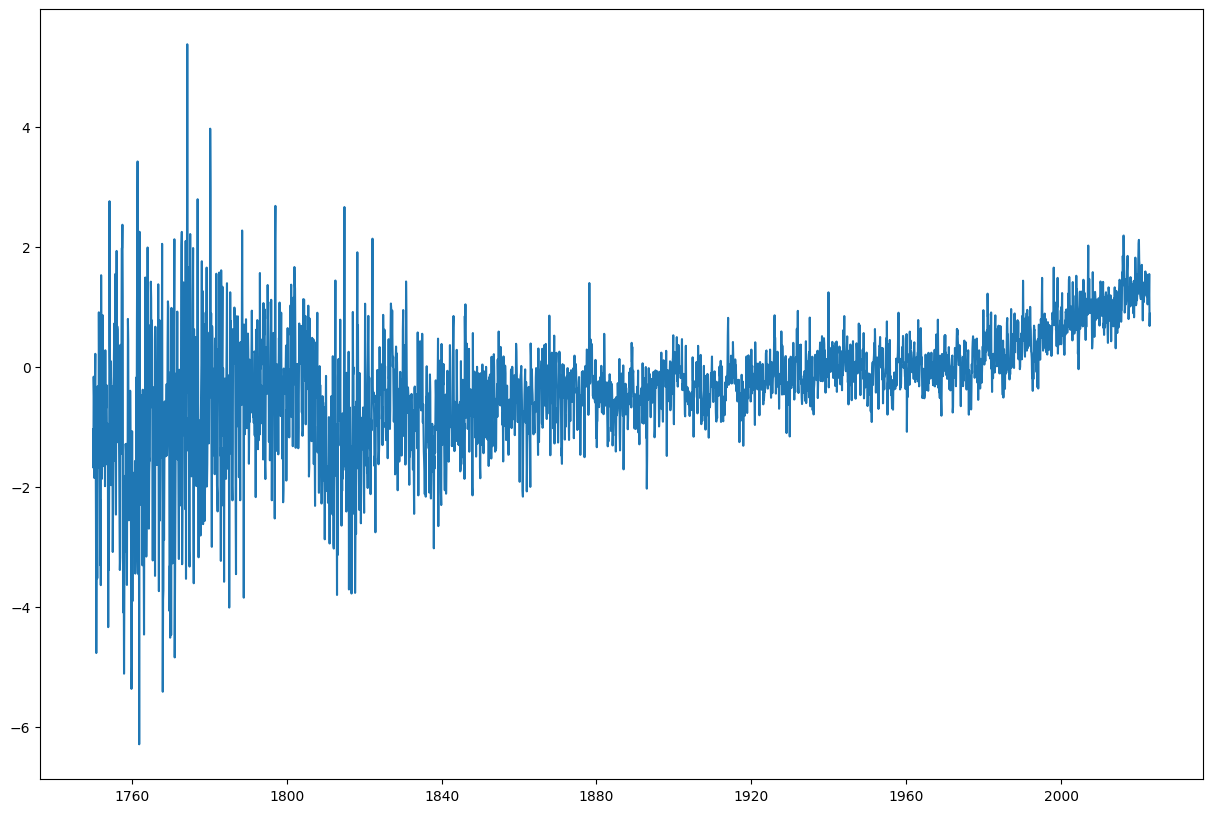

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(dataset)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.savefig('monthly_anomalies', bbox_inches='tight', transparent=False)

The increase has been tremendous, but it seems to start to plateau. Maybe too early to know? I'd leave that discussion to the scientists in charge.<br>

This time series is obvious non-stationary, and we cannot observe any seasonal behavior here. Let's make it stationary by taking the difference between consecutive elements, which in our case will be the daily change in the number of deaths. To do this, we will use the `diff` method from the Dataframe object.


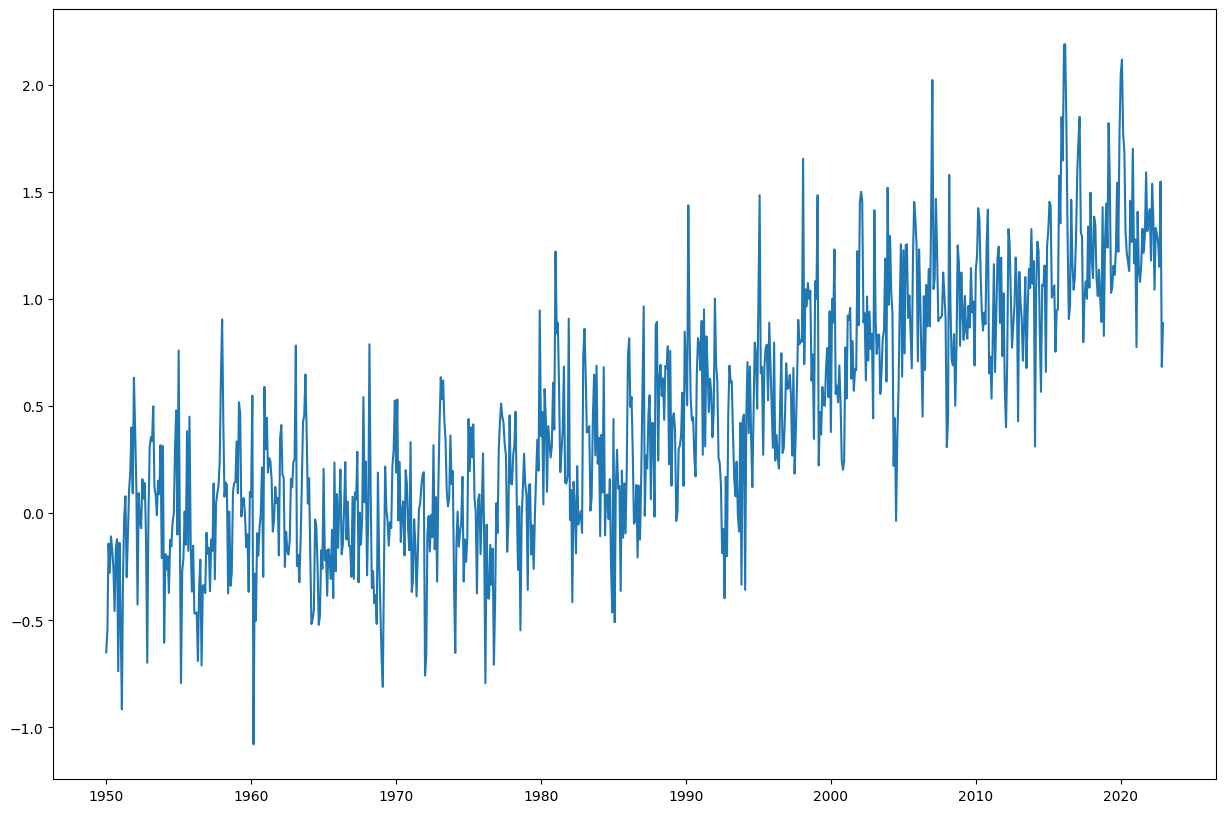

In [10]:
sample = dataset.loc['1950-01-01':'2023-01-01']
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(sample)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.savefig('monthly_anomalies_sample', bbox_inches='tight', transparent=False)

This time series is obvious non-stationary, and we cannot observe any seasonal behavior here. Let's perform seasonal decomposition of the data by using the `seasonal_decompose()` function from `statsmodel`. However, this function doesn't deal with `NaN` values, which we have a few of in the 18th century. So let's only analyse years starting from 1800 by using the pandas query `dataset.loc[dataset.index >= pd.to_datetime('1800-01-01')]`:

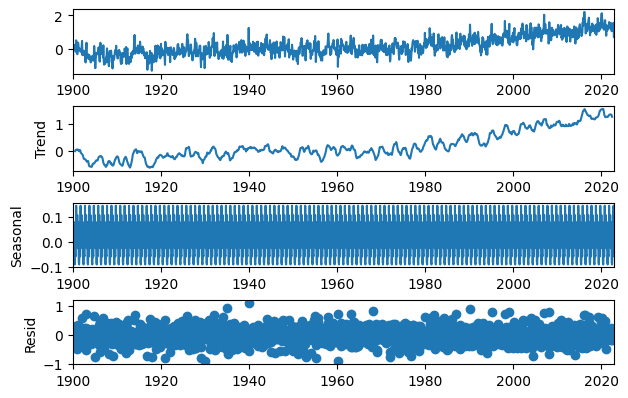

In [43]:
import statsmodels.api as sm
dataset = dataset.loc[dataset.index >= pd.to_datetime('1900-01-01')]
seas_d=sm.tsa.seasonal_decompose(dataset,model='add')
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

There is a yearly seasonality in the data, and there is also a trend. The anomaly heading upwards, which isn't good!

Therefore, it is not yet stationary, so let's take the `diff()`.

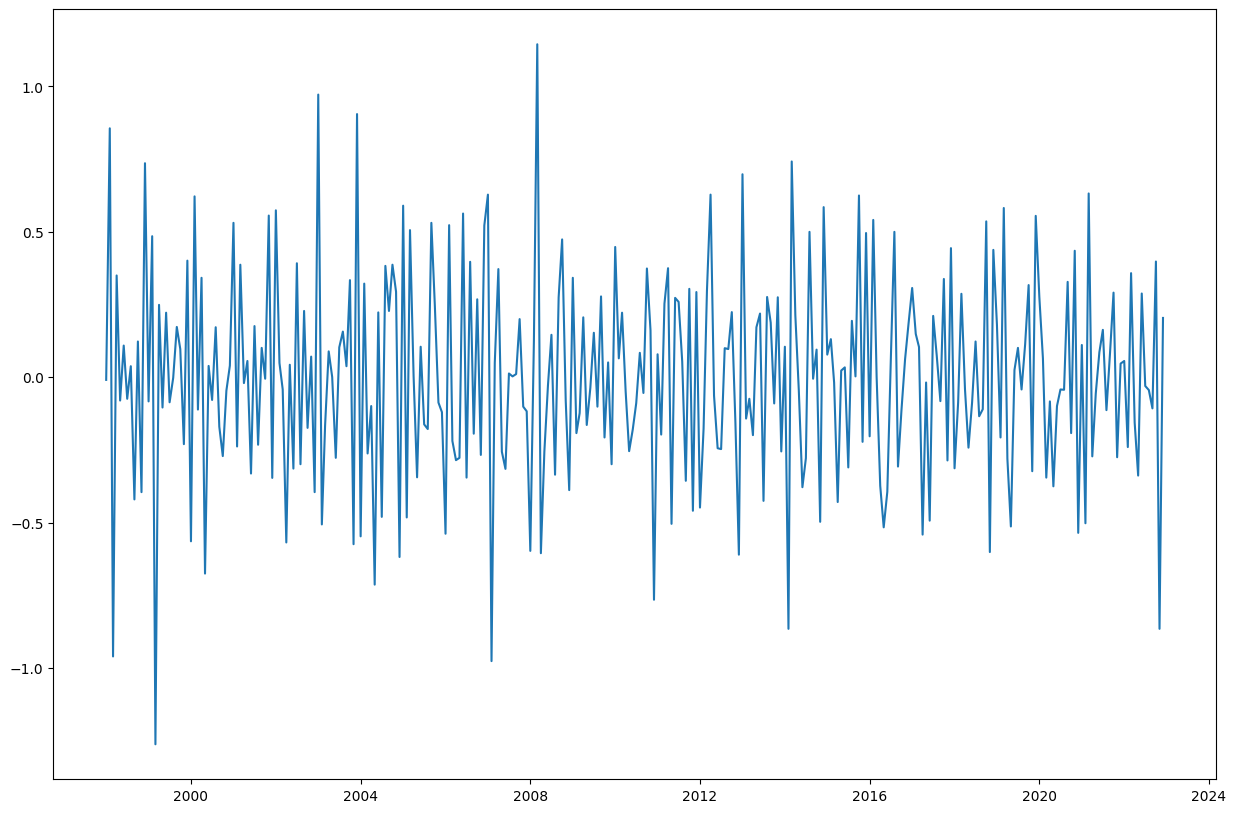

In [44]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(dataset.diff().tail(300))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.savefig('monthly_anomalies', bbox_inches='tight', transparent=False)

This is clearly stationary enough, and we will be using this for our subsequent analysis.

In [45]:
dataset.head()

,y
date,
1900-01-01,-0.953
1900-02-01,-0.000
1900-03-01,0.252
1900-04-01,-0.049
1900-05-01,0.187


In [46]:
dataset_diff = dataset.diff()
dataset_diff.head()

,y
date,
1900-01-01,NaN
1900-02-01,0.953
1900-03-01,0.252
1900-04-01,-0.301
1900-05-01,0.236


We need to remove the first two data point here, which will be a None value when `diff()` calculates its difference from the non-existing data point before it (there's nothing before it):

In [47]:
dataset_diff = dataset_diff.iloc[1:]
dataset_diff.head()

,y
date,
1900-02-01,0.953
1900-03-01,0.252
1900-04-01,-0.301
1900-05-01,0.236
1900-06-01,-0.252


Now that we got the diff of the data, and let's say we are going to train models to predict that diff, how can we restore the original data values from a diff? To do that, we use the following procedure:

In [48]:
dataset_diff_inv=dataset.shift(1) + dataset_diff

In [49]:
print(dataset.head())
print(dataset_diff_inv.head()) 

                y
date             
1900-01-01 -0.953
1900-02-01 -0.000
1900-03-01  0.252
1900-04-01 -0.049
1900-05-01  0.187
                y
date             
1900-01-01    NaN
1900-02-01  0.000
1900-03-01  0.252
1900-04-01 -0.049
1900-05-01  0.187


As you can see here: we can restore the `y` based on the values in `diff()`, but we will miss the first value of `y`, which is totally find.

But we are missing something here: even though this method works, it won't work when we want to inverse the `diff()` in forecasted data, because in that case we will not have the `y` of the forecasted data. So what should we do?

An alternative way to inverse the `diff()`, which works for the case of forecasted data, is to use the `np.cumcom()` cummulative summation function.

The first thing to do when using this function is to place the first value of `y` as the first value in `diff()`.

In [50]:
dataset_diff_sub = dataset.diff()
dataset_diff_sub.y[0] = dataset.y[0]
dataset_diff_inv=np.cumsum(dataset_diff_sub)
print(dataset.diff().head())
print(dataset_diff_sub.head())


                y
date             
1900-01-01    NaN
1900-02-01  0.953
1900-03-01  0.252
1900-04-01 -0.301
1900-05-01  0.236
                y
date             
1900-01-01 -0.953
1900-02-01  0.953
1900-03-01  0.252
1900-04-01 -0.301
1900-05-01  0.236


In [51]:

print(dataset_diff_inv.head())
print(dataset.head())

                y
date             
1900-01-01 -0.953
1900-02-01  0.000
1900-03-01  0.252
1900-04-01 -0.049
1900-05-01  0.187
                y
date             
1900-01-01 -0.953
1900-02-01 -0.000
1900-03-01  0.252
1900-04-01 -0.049
1900-05-01  0.187


Here we go. The two datasets are identical. We will use this apprach to calculate the actual temperature values after obtaining the forcasted values.

The last step in this task is to split our dataset into a training and a test set. When we train ML models, we typically use 20% of the dataset as a test set. In time series analysis, the the size of the test set should be close to the extent of the future data. In this exercise, we are only going to predict 1 month into the future. Therefore, we will use all the data before 15 April 2022 as training set.



cutoff_date 2022-01-01
end_date 2022-12-01 00:00:00


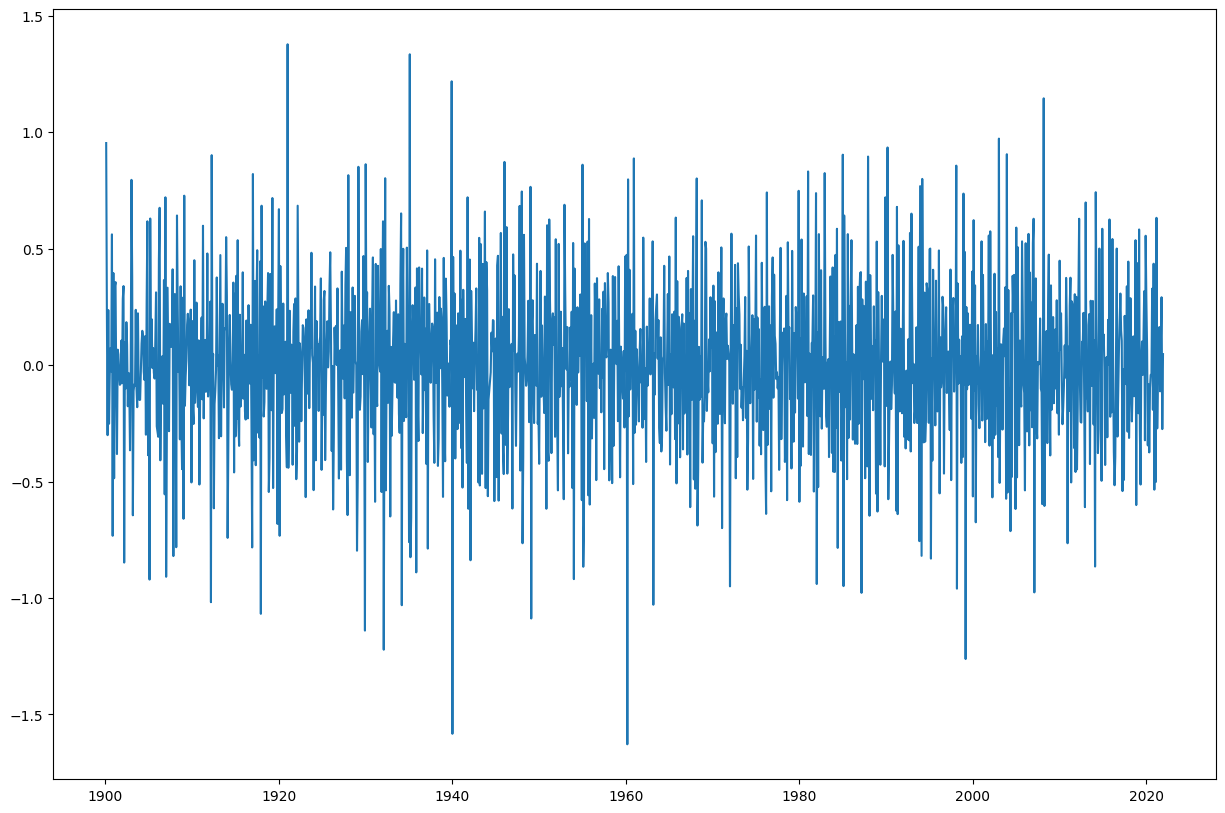

In [56]:
cutoff_date = '2022-01-01'
end_date = dataset_diff.index[-1]
print('cutoff_date',cutoff_date)
print('end_date',end_date)

train = dataset_diff.loc[dataset_diff.index < pd.to_datetime(cutoff_date)]
test = dataset_diff.loc[dataset_diff.index >= pd.to_datetime(cutoff_date)]


fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(train)

plt.savefig('monthly_anomalies_training_set', bbox_inches='tight', transparent=False)

# Task 3: Forcasting using SARIMAX, or Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

SARIMAX is one of the time series models in the python statistics library statsmodels.

Now let's talk about SARIMAX.

In [57]:
model = SARIMAX(train, order=(4, 2, 2),seasonal_order=(0,0,0,12))

Next, we call the fit method to optimize the model.

In [58]:
results = model.fit()

Now let's make predictions using the model, and compare those against the values in the test set.

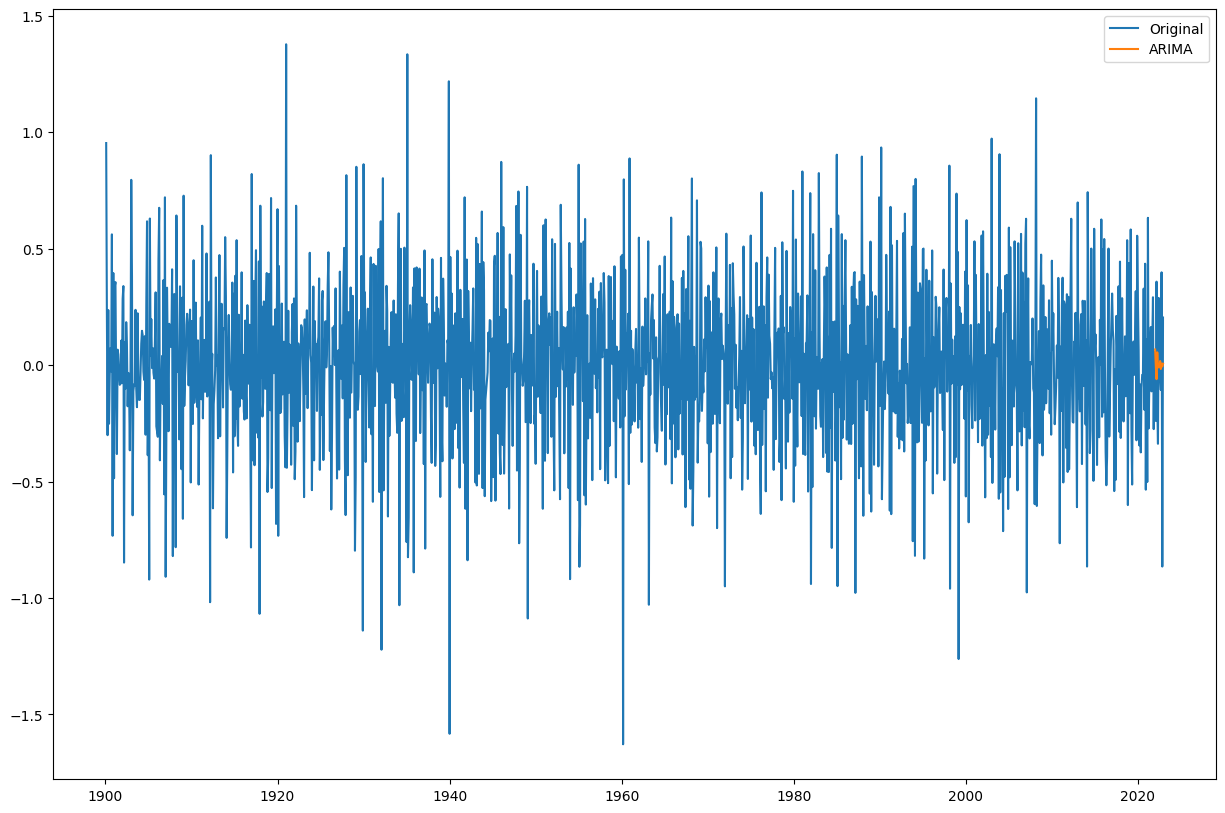

In [59]:
sarimax_prediction = results.predict(
    start=cutoff_date, end=end_date)

fig, ax = plt.subplots(figsize=(15, 10))
l1, = ax.plot(dataset_diff, label='Original')
l2, = ax.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1, l2])
plt.savefig('SARIMAX_prediction', bbox_inches='tight', transparent=False)

Since that we are interested in comparing between the different time series analysis approaches, we are going to use one of the validation measures: mean absolute error.

In [60]:
print('SARIMAX MAE = ', mean_absolute_error(sarimax_prediction, test))

SARIMAX MAE =  0.2599557340383878


However, in a typical machine learning workflow, we should find the best values of p, q and r that will minimize the error. We can use the auto_arima function in the pmdarima module to do that. This will find the optimal parameter combintation and return the best model. This is going to take a few minutes.


In [63]:
model = pm.auto_arima(train,
                      start_p=1, start_q=1, 
                      d=1, max_d=7,
                      m=12,
                      seasonal=True,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=4.54 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2688.807, Time=0.21 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1914.839, Time=0.71 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=3.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2686.809, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1917.122, Time=0.19 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1888.906, Time=2.45 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=13.01 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=4.21 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=2665.738, Time=1.48 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1560.941, Time=3.35 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1576.124, Time=1.00 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=13.22 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=4.96 sec
 ARIMA(3,1,0)(2,0,0)[12] intercept   : AIC=1362

Note that this gives us the best mode here: "Best model:  SARIMAX(5,1,0)(2,0,0)[12]". Now let's fit it.

SARIMAX MAE =  0.2679469041069053


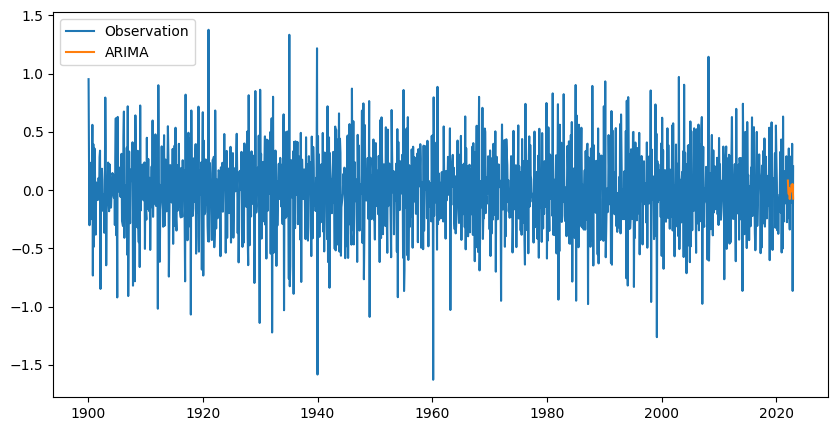

In [64]:
# model = SARIMAX(train, order=(5, 1, 0),seasonal_order=(2,0,0,12))
# results = model.fit()
sarimax_prediction = model.predict(n_periods=test.shape[0])
sarimax_prediction = pd.DataFrame({'ds':test.index,'y':sarimax_prediction})
sarimax_prediction.set_index('ds',inplace=True)

plt.figure(figsize=(10, 5))
l1, = plt.plot(dataset_diff, label='Observation')
l2, = plt.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1, l2])
plt.savefig('SARIMAX_prediction', bbox_inches='tight', transparent=False)
print('SARIMAX MAE = ', mean_absolute_error(sarimax_prediction, test))

Let's run the standard diagnostics:

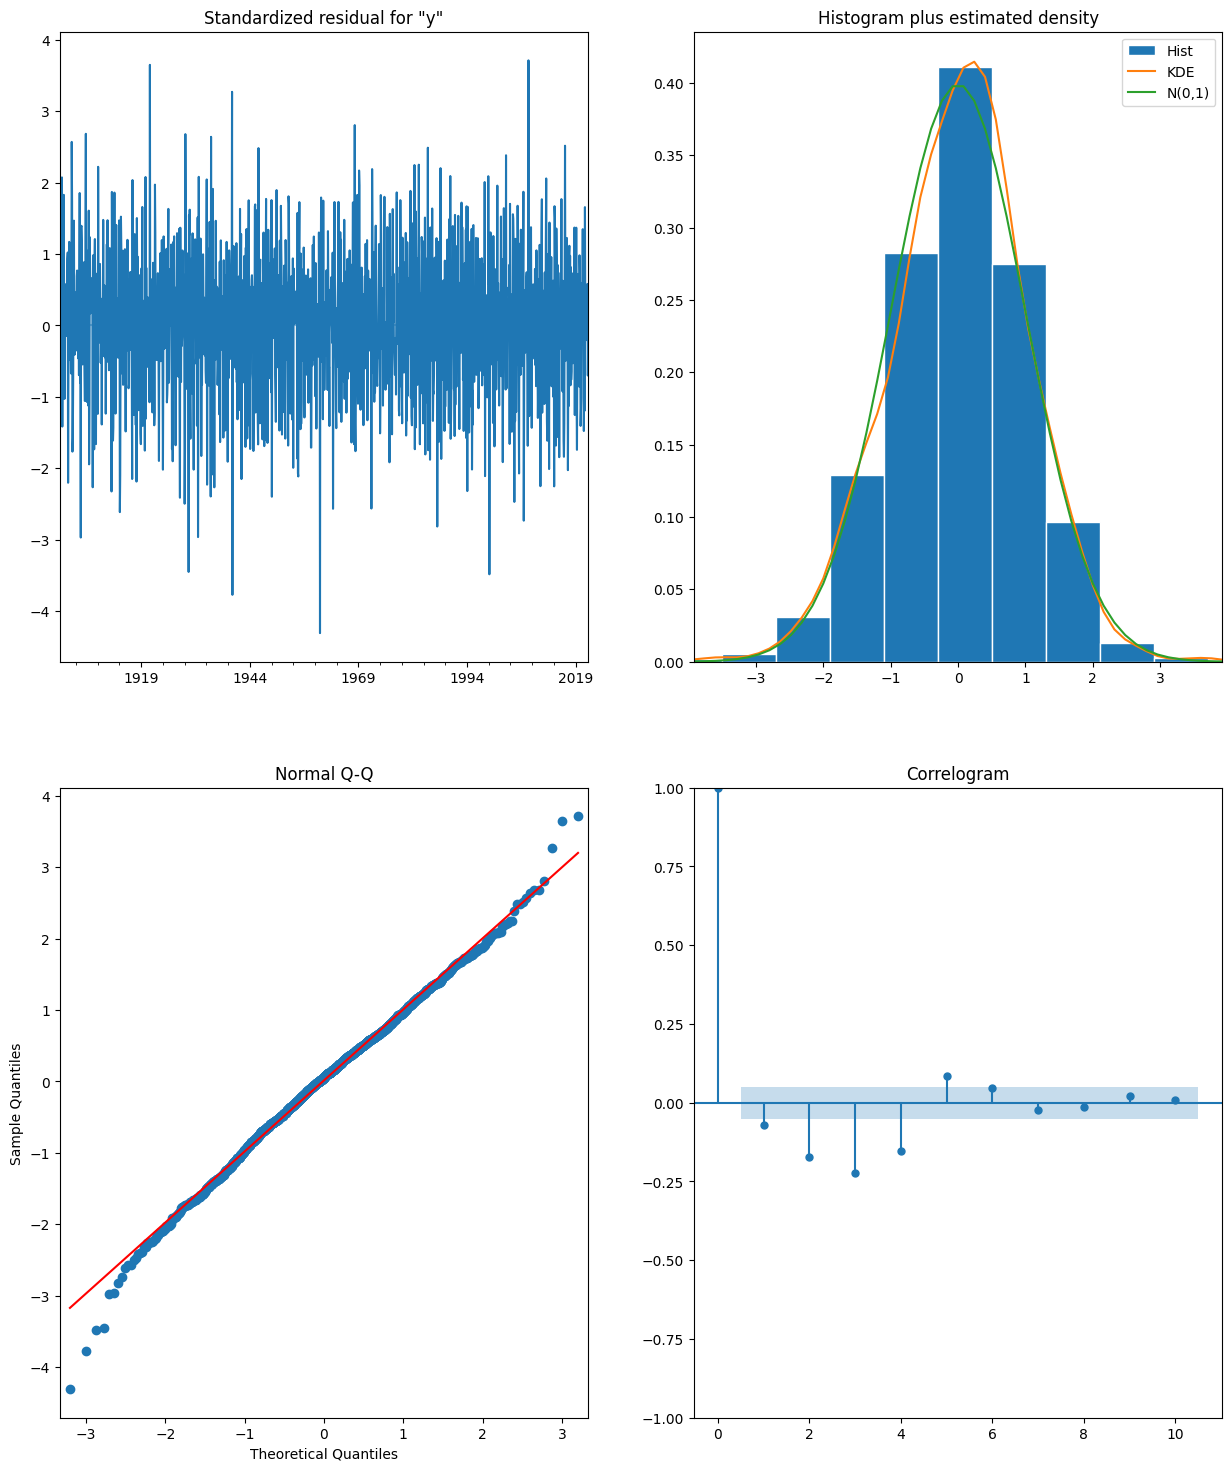

In [69]:
results.plot_diagnostics(figsize=(15, 18))
plt.show()

- The diagnostic plots enable us to analyse the accuracy of our model, and whether there is any (residual) information in the data that should be used to improve the model.
- The package provides four diagnostic plots. Below I only give a very brief description of these plots.
  - Standardized residuals over time plot: Calculates the residue, or the difference between observed and predicted values, as a function of time.
  - Histogram: It's the count of values against the computed residual. Note: that residual in the x-axis was the one in the y-axis in the plot above.
  - Normal Q-Q: Typically, model errors should be normally distributed. This plot checks if this is the case; if the points are nearly linear, then the errors are normally distributed. Which is the case in our plot.
  - Correlogram: Checks the autocorrelation in the data, to ensure that the data is random. 
- *Randomness of data* is a necessary condition for the *validity* of the model, and it is checked by the correlogram.
- In the correlogram, the *autocorrelation* is plotted against *time lags*. If the values are close to zero, then this is an indication of the randomness of the data, as is the case in our plot above.

In [70]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Preparing the dataset for XGBOOST and NN

Unlike the prophet and SAIMAX models, the two models we will train in Task 6, namely XGBOOST and NN, are supervised machine learning models that deal with independent data points, or examples. It assumes that each data point is totally independent from the rest of the data points in the dataset.

Here is a method that extracts these features from a given dataframe object.

In [71]:
def featurize(t):
    X = pd.DataFrame()

    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    y = t.y
    return X, y


featurize(dataset_diff)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,1,2,1,3,32,5
1,1,3,1,3,60,9
2,1,4,2,6,91,13
3,1,5,2,1,121,18
4,1,6,2,4,152,22


# Create training and test datasets by splitting the dataset, and perform data normalization.

In this task we are going to cover two topics in data preparation: splitting the dataset into training and test data, and normalizing the data.

You might have already performed a splitting operation of a dataset in machine learning, where one takes a randomly selected portion of the dataset, say 20%, as a test set, while the remaining 80% is the training set. It is randomly selected because the whole dataset is randomly shufflled before the selection. Another popular approach is the k-fold cross validation.

However, those two methods won't work with time series data. The reason is: when we train the model on the training set, the purpose is to predict the target values in the future, which corresponds to date values that are outside of the date values in the training set.

In [72]:
X_train, y_train = featurize(
    dataset_diff.loc[dataset_diff.index < pd.to_datetime(cutoff_date)])
X_test, y_test = featurize(
    dataset_diff.loc[dataset_diff.index >= pd.to_datetime(cutoff_date)])

Now let's discuss data normalization. We perform data normalization so as to make the range of values of the features, or the columns in the X_train table, as close as possible. For example, we have the features dayofweek and dayofyear. The range of values of dayofweek is from 1 to 7, whereas dayofyear is from 1 to 365. Having such large differences in the ranges of values will either slow down the training of the machine learning model or make it quite difficult. We solve this problem by applying normalization. There are several ways we can normalize the data with. Here I will choose the StandardScaler, which applies the following equation on each of the columns.

z = (x - u) / s

Here x is the column before scaling, u is thee mean and s is the standard deviation. So basically, we subtract the mean of each column from itself, then divide by the standard deviation of that column. To apply StandardScaler, we first fit the scaler object to the dataset:


In [74]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

Apply the scaling to both the training and test sets, as follows.

In [75]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

# Train the XGBOOST and NN models

First, create the XGBRegressor object which will represent the XGBOOST regression model.

In [76]:
XGBOOST_model = XGBRegressor(n_estimators=7)


Next, train the XGBOOST regression model using the fit method, and perform prediction using the predict method.

In [77]:
XGBOOST_model.fit(scaled_train, y_train,
                  eval_set=[(scaled_train, y_train), (scaled_test, y_test)],
                  verbose=True)
XGBOOST_prediction = XGBOOST_model.predict(scaled_test)

[0]	validation_0-rmse:0.49633	validation_1-rmse:0.50159
[1]	validation_0-rmse:0.42513	validation_1-rmse:0.41656
[2]	validation_0-rmse:0.38455	validation_1-rmse:0.36445
[3]	validation_0-rmse:0.36171	validation_1-rmse:0.33259
[4]	validation_0-rmse:0.34973	validation_1-rmse:0.31627
[5]	validation_0-rmse:0.34345	validation_1-rmse:0.30803
[6]	validation_0-rmse:0.33967	validation_1-rmse:0.30742


Let us calculate the mean absolute error for the training.

In [78]:
print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))

XGBOOST MAE =  0.24584652211268745


Creation and training of the feedforward neural network model.

In [79]:
NN_model = Sequential()
NN_model.add(Dense(20, input_shape=(scaled_train.shape[1],)))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))
NN_model.fit(scaled_train, y_train, validation_data=(
    scaled_test, y_test), epochs=210, verbose=1)
NN_prediction = NN_model.predict(scaled_test)

Epoch 1/210
46/46 [==============================] - 1s 6ms/step - loss: 0.4490 - val_loss: 0.3137
Epoch 2/210
46/46 [==============================] - 0s 3ms/step - loss: 0.3203 - val_loss: 0.2436
Epoch 3/210
46/46 [==============================] - 0s 3ms/step - loss: 0.2933 - val_loss: 0.2512
Epoch 4/210
46/46 [==============================] - 0s 3ms/step - loss: 0.2829 - val_loss: 0.2568
Epoch 5/210
46/46 [==============================] - 0s 3ms/step - loss: 0.2786 - val_loss: 0.2652
Epoch 6/210
46/46 [==============================] - 0s 3ms/step - loss: 0.2773 - val_loss: 0.2569
Epoch 7/210
46/46 [==============================] - 0s 3ms/step - loss: 0.2796 - val_loss: 0.2728
Epoch 8/210
46/46 [==============================] - 0s 3ms/step - loss: 0.2766 - val_loss: 0.2750
Epoch 9/210
46/46 [==============================] - 0s 3ms/step - loss: 0.2765 - val_loss: 0.2704
Epoch 10/210
46/46 [==============================] - 0s 2ms/step - loss: 0.2761 - val_loss: 0.2654
Epoch 11/

Let's compare the MAE values.

In [81]:
print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))
print('SARIMAX MAE = ', mean_absolute_error(sarimax_prediction, test))
print('NN MAE = ', mean_absolute_error(NN_prediction, test))


XGBOOST MAE =  0.24584652211268745
SARIMAX MAE =  0.25404619206928586
NN MAE =  0.268847431169978


The peformance of SARIMAX is the best, while that of XGBOOST is the worst. <br>
Finally let us visualize the predictions of all 4 models. Note the autofmt_xdate method in matplotlib, it knows how to appropriately rotate the date labels on the x-axis.

<Figure size 4000x2000 with 0 Axes>

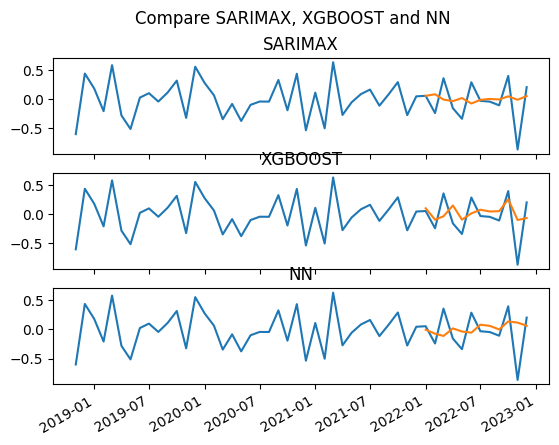

In [83]:

XGBOOST_df = pd.DataFrame({'y': XGBOOST_prediction.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index
plt.figure(figsize=(40, 20))
fig, axs = plt.subplots(3, 1)
fig.suptitle('Compare SARIMAX, XGBOOST and NN')
axs[0].plot(dataset_diff.tail(50))
axs[0].plot(sarimax_prediction.tail(50))
axs[0].set_title("SARIMAX")
axs[1].plot(dataset_diff.tail(50))
axs[1].plot(XGBOOST_df.tail(50))
axs[1].set_title("XGBOOST")
axs[2].plot(dataset_diff.tail(50))
axs[2].plot(NN_df.tail(50))
axs[2].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)

# Part 8: Forecast the future

- We have established the XGBOOST model is the most accurate, and therefore we can use it to forcast the future COVID19 deaths i.e. beyond 15th May 2022.
- For the sake of exercise, we will apply all four models for the forecast.
- We will ask the four models to forecast 1 month into the future: from 16th May 2022 to 16th June 2022.
- Prediction with SARIMAX and fbprophet is straightforward:

In [85]:
sarimax_future_prediction = results.predict(start=dataset_diff.index[0], end='2027-01-01', dynamic=True)
future = pd.DataFrame({'ds':pd.date_range(start=dataset_diff.index[0], end='2027-01-01')})


- For XGBOOST and NN, we need to generate the `X` dataset as we did before. We need to create a new function like `featurize()`, which takes a DataFrame of dates only.

In [86]:
def featurize_dates(t):
    X = pd.DataFrame()

    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    return X


Let's apply it on the `future` DataFrame we got from fbprophet to generate forecasts using the trained XGBOOST model:

In [87]:
future = future.set_index('ds')
X_future = featurize_dates(future)
scaled_future = scaler.transform(X_future)
XGBOOST_future = XGBOOST_model.predict(scaled_future)

We do the same for the NN:

In [88]:
NN_future = NN_model.predict(scaled_future)

1449/1449 [==============================] - 2s 1ms/step


Finally, let's plot the entire time series including training, test and future predictions:

<Figure size 4000x2000 with 0 Axes>

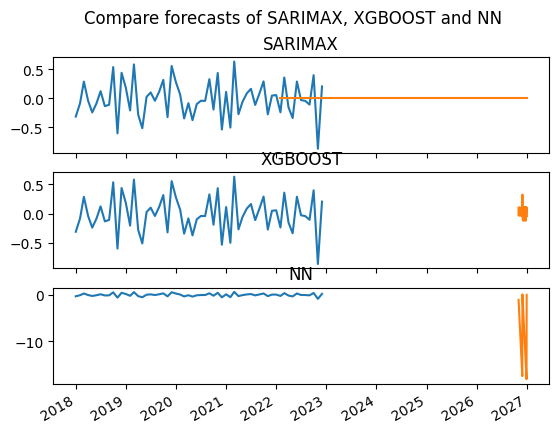

In [89]:

XGBOOST_df = pd.DataFrame({'y': XGBOOST_future.tolist()})
XGBOOST_df.index = future.index

NN_df = pd.DataFrame(NN_future)
NN_df.index = future.index

future_prediction_count = 5*12 + test.shape[0]

plt.figure(figsize=(40, 20))
fig, axs = plt.subplots(3, 1)
fig.suptitle('Compare forecasts of SARIMAX, XGBOOST and NN')
axs[0].plot(dataset_diff.tail(60))
axs[0].plot(sarimax_future_prediction.tail(60))
axs[0].set_title("SARIMAX")
axs[1].plot(dataset_diff.tail(60))
axs[1].plot(XGBOOST_df.tail(60))
axs[1].set_title("XGBOOST")
axs[2].plot(dataset_diff.tail(60))
axs[2].plot(NN_df.tail(60))
axs[2].set_title("NN")


for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison_forecasts',
            bbox_inches='tight', transparent=False)